# Notebook Detección Corte de hoja
<img src="Logo Arauco 1.png">
<img src="Logo Arauco 2.png">

Este notebook es creado para el entrenamiento de red neuronal para detección de corte de hoja de maquina L2.
Es importante que cada vez que se realicen cambios al codigo queden documentados indicando:
- Razon de la modificación
- Fecha de modificación
- Quien ejecuto la modificación

Lo que buscamos con utilizar este notebook es que todos podamos documentar y aportar en la creación del modelo.
Los integrantes del equipo de trabajo son:
- Leonardo Bravo
- Victor Encina
- Yamil Avello
- Guillermo Viñas
- Felipe Santander

El Notebook fue creado el 10.09.2019.

1-. Instalado modulo de TensorFlow (10.09.2019)

**Felipe Santander** 

### Instalación de SW

In [ ]:
#IMPORTANTE: Instalar tensorflow y pandas al correr por primera vez notebook
!pip install --upgrade pip
!pip install jupyter
!pip install tensorflow
#!conda install pandas
!pip install pandas
!pip install matplotlib

## 1. Importación 
### 1.1 Importación de librerias

In [ ]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
pd.__version__
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

### 1.2 Importación de datasets
Se importan los datasets previamente rescatados, estos deben ser guardados en la carpeta raiz de notebook:

In [3]:
#Cargar datasets para entrenamiento
#print(os.getcwd())
#print(os.listdir())
X_mean=[]
X_Train = pd.read_csv('/home/jovyan/X_Train_2018.csv',delimiter=';',engine='python')
Y_Train = pd.read_csv('/home/jovyan/Y_Train_2018.csv',delimiter=';',engine='python')
#print(np.sum(X_Train.isnull()))
X_Train=X_Train.values.T
Y_Train=Y_Train.values.T
X_Train=X_Train.astype(np.float)
Y_Train=Y_Train.astype(np.float)
print("La dimension de set de entrenamiento es X: ",X_Train.shape)
print("La dimension de set de entrenamiento es Y: ",Y_Train.shape)         

La dimension de set de entrenamiento es X:  (53, 5580)
La dimension de set de entrenamiento es Y:  (1, 5580)


### 1.3 Normalización set de datos
La normalización de datos tiene por objetivo normalizar a por unidad todos los datos de entrada, es decir en rango de $[0,1]$ para extraer efectivamente la información de cada una de las variables alimentada al modelo.

Para la normalización de las variables se utilizaron dos formas:
1. Normalización de datos:
$$X_{norm}=\frac{(X-X_{Min})}{(X_{Max}-X_{Min})}\tag{1}$$
2. Estandarización de datos
$$X_{std}=\frac{(X-\bar{X})}{\sigma}\tag{2}$$
 (Desviación estandar): $ \sigma = \sqrt[]{\frac{1}{N-1}\sum_{i=1}^{N}X_i-\bar{X}}\tag{3}$

In [4]:
X_max=np.zeros((X_Train.shape[0],1))
X_min=np.zeros((X_Train.shape[0],1))

#print(data[data.HOJA == 'CORTE'])
i=0

mean=np.reshape(np.mean(X_Train,axis=1),(53,1),order='F')
var=np.reshape(np.var(X_Train,axis=1),(53,1),order='F')
devstd=np.reshape(np.std(X_Train,axis=1),(53,1),order='F')
cont=X_Train.shape[0]
for i in range(cont):
        X_max[i]=np.max(X_Train[[i]])
        X_min[i]=np.min(X_Train[[i]])
X_gain=X_max-X_min
X_train_norm=np.divide(X_Train-X_min,X_gain)
X_train_std=np.divide((X_Train-mean),devstd)
#X_max[52]=np.max(X_Train[[52]])
#print(np.max(X_Train[[52]]))
#print(np.min(X_Train[[52]]))
#print("X_max: ",X_max[[52]])
#print("X_min: ",X_min[[52]])

print("La dimension de los datos originales es",X_Train.shape)
print("La dimension de los datos normalizados es",X_train_norm.shape)
print("La dimension de los datos estandarizados es",X_train_std.shape)

La dimension de los datos originales es (53, 5580)
La dimension de los datos normalizados es (53, 5580)
La dimension de los datos estandarizados es (53, 5580)


### 1.3 Creación de Minibatch
Para acelerar los entrenamientos se crean sets de datos mas pequeños de forma que no es necesario explorar el sets de datos completos para obtener una aproximacion de las matrices de pesos y bias, y a cada exploracion de minibatch se obtiene una optimización de los parametros de la red neuronal.
El ideal es que los tamaños de los minibatches sea de numero par consistentes con cuentas binarias (32,64,128,512...) de manera de optimizar el tamaño de uso de memoria RAM.

In [5]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Comprobación de correcto funcionamiento de función

```Random_mini_batches(X_{}train,Y_{}Train,32,1)```


In [6]:
mini_batches = random_mini_batches(X_Train, Y_Train,32,1)
print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (53, 32)
shape of the 2nd mini_batch_X: (53, 32)
shape of the 3rd mini_batch_X: (53, 32)
shape of the 1st mini_batch_Y: (1, 32)
shape of the 2nd mini_batch_Y: (1, 32)
shape of the 3rd mini_batch_Y: (1, 32)
mini batch check: [1.19762304 1.19976401 1.2003721 ]


## 2. Creación Red Neuronal

### 2.1 Función para creación de vectores.

In [7]:
def create_placeholders(n_x, n_y):
    """
    Crea los placeholders para la sesion de tensorflow.
    
    Arguments:
    n_x -- escalar, tamaño de variables de entradas
    n_y -- escalar, numero de calisificadores (caso particular de detección corte de hoja 1)
    
    Returns:
    X -- placeholder para los datos de entrada, de dimension [n_x, None] y dtype "float"
    Y -- placeholder para las etiquetas de salida, de dimensión [n_y, None] y dtype "float"
    """
    
    X = tf.placeholder(tf.float32, shape=(n_x,None))
    Y = tf.placeholder(tf.float32,  shape=(n_y,None))
    
    return X, Y

### 2.3 Función de inicialización de parametros
Se inicializan las matrices de peso y bias de la red neuronal.
En este bloque es donde se indica la cantidad de neuronas que tendra cada capa.

Inicialmente la cantidad de neuronas en las capas ocultas es la siguiente:

* $Capa_1: 15$
* $Capa_2: 15$
* $Capa_3: 1$

In [16]:
def initialize_parameters():
    """
    Inicializa los parametros para crear la red neuronal en tensorflow. Las dimensiones son:
                        W1 : [15, 53]
                        b1 : [15, 1]
                        W2 : [15, 15]
                        b2 : [15, 1]
                        W3 : [1, 15]
                        b3 : [1, 1]
    
    Salida:
    parameters -- dictionario que contiene W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)
    W1 =tf.get_variable("W1", [15,53], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [15,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [6,15], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [6,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1,6], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [1,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

### 2.4 Función Feedforward

Se construye red neuronal con funciones de activación sigmoidales de tres capas:
<img src="Arquitectura Red.png">

---

Matematicamente es:

$$Z^{[1]}=W^{[1]}*X_{norm}+B_{[1]}\small\tag{1}$$
$$Z^{[i]}=W^{[i]}*Z^{[i]}+B_{[i]}\small\tag{2}$$
$$A^{[i]}=sigmoid(Z^{[i]})=\sigma(Z^{[i]})\small\tag{3}$$
$$\hat{y}=\sigma(Z^{[3]})\small\tag{4}$$


In [17]:
def forward_propagation(X, parameters):
    """
    Implementación de forward propagation: LINEAR -> SIGMOID -> LINEAR -> SIGMOID -> LINEAR -> SIGMOID
    
    Arguments:
    X -- entrada dataset placeholder, de dimension (tamaño entrada, numero de muestras)
    parameters -- contiene los parametros "W1", "b1", "W2", "b2", "W3", "b3"
                  las dimensiones son dadas por la función de inicialización

    Salida:
    Z3 -- salida de la ultima función LINEAR
    """
    
    # Rescata los parametros desde el diccionario "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3

### 2.5 Función Costo

La función de costo utilizada es:
$$ J = - \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log a^{ [2] (i)} + (1-y^{(i)})\log (1-a^{ [2] (i)} )\large )\small\tag{5}$$
La función de costo (5) es conocida como "*sigmoid cross entropy*" y en tensorflow puede ser llamada como:

```tf.nn.sigmoid_cross_entropy_with_logits()```

In [18]:
def compute_cost(Z3, Y):
    """
    Calculo costo
    
    Argumentos:
    Z3 -- salida de forward propagation (salida de la ultima función LINEAR), de dimension (1, numero de muestras)
    Y -- "true" vector de etiquetas placeholder, misma dimension que Z3
    
    Salida:
    cost - Tensor de la función de costo
    """
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

### 2.6 Construcción del Modelo
Se utilizan las funciones generadas antes para construir el modelo de la red neuronal y generar el entrenamiento utilizando los minibatch ya generados. Los parametros que pueden ser modificados para la busqueda de mejor comportamiento del modelo son los siguientes:
* learning rate ```learning_rate```: tamaño de la corrección por cada iteración obtenida desde el algoritmo Adam.
* numero de epocas ```num_epochs```: numero de veces que explorará todos los minibatches.
* tamaño de minibatch ```minibatch_size```: tamaño de los minibatch.

In [22]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implementa tres-capas tensorflow red neuronal: LINEAR->SIGMOID->LINEAR->SIGMOID->LINEAR->SIGMOID.
    
    Argumentos:
    X_train -- training set, de dimension (tamaño entradas = 53, numero de muestras = 1080)
    Y_train -- test set, de dimension (tamaño salida = 1, numero de muestras = 1080)
    X_test -- training set, de dimension (tamaño entradas = 53, numero de muestras = 1080)
    Y_test -- test set, de dimension (tamaño salida = 1, numero de muestras = 1080)
    learning_rate -- learning rate de la optimización
    num_epochs -- number de epocas de ciclo de optimización
    minibatch_size -- tamaño minibatch
    print_cost -- True para imprimir el costo cada 100 epocas
    
    Salida:
    parameters -- parametros aprendidos por el modelos.
    """
    
    ops.reset_default_graph()                         # para correr modelo sin sobreescribir tf variables
    tf.set_random_seed(1)                             # para mantener resultados consistentes
    seed = 3                                          # para mantener resultados consistentes
    (n_x, m) = X_train.shape                          # (n_x: tamaño set entradas, m : numeros de muestras en el dataset)
    n_y = Y_train.shape[0]                            # n_y : tamaño de salida
    costs = []                                        # para mantener seguimiento de función de costo
    print("n_x: ",n_x)
    print("n_y: ",n_y)
    # Crea variables de tf de orden (n_x, n_y)
    X, Y = create_placeholders(n_x,n_y)

    # Inicializa parametros
    parameters = initialize_parameters()
    
    # Forward propagation: construye forward propagation en el grafico de tensorflow
    Z3 = forward_propagation(X, parameters)
    
    # Función de costo: Incluye la función de costo en el grafico de tensorflow
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define el optimizador de tensorflow. Usa AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Inicializa todas las variables
    init = tf.global_variables_initializer()

    # Inicia la sesión para computar el grafico de tensorflow
    with tf.Session() as sess:
        
        # Corre initialization
        sess.run(init)
        
        # Realiza training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
        
                # Selecciona minibatch
                (minibatch_X, minibatch_Y) = minibatch
                #print(minibatch_X[1][0])
                
                #IMPORTANTE: Función que ejecuta optimización en tensorflow
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Muestra el costo en cada epoca
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # grafica el costo
        plt.plot(np.squeeze(costs))
        plt.ylabel('costo')
        plt.xlabel('iteraciones (x10)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Guarda los parametros en una variable
        parameters = sess.run(parameters)
        print ("Los parametros han sido entrenados!")

        # Calcula las predicciones correctas
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calcula el accuracy en el test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
        W3 = parameters['W3']
        b3 = parameters['b3']
        print("W1= ", W1)
        print("b1= ", b1)
        print("W2= ", W2)
        print("b2= ", b2)
        print("W3= ", W3)
        print("b3= ", b3)
        return parameters

### 2.7 Entrenamiento Red Neuronal
Se entrena la red neuronal utilizando el set de datos normalizado, como resultado se obtendra:
1. Cada 100 epocas imprimira el valor de la función de costo que se esta optimizando
2. Al finalizar la iteración por la cantidad de epocas imprimira el grafico de evolución de la función de costo
3. Imprimira el valor de cada una de las matrices de pesos y bias de cada capa

n_x:  53
n_y:  1
Cost after epoch 0: 0.652608
Cost after epoch 100: 0.003191
Cost after epoch 200: 0.000361
Cost after epoch 300: 0.000195
Cost after epoch 400: 0.000039
Cost after epoch 500: 0.000041
Cost after epoch 600: 0.000457
Cost after epoch 700: 0.000023
Cost after epoch 800: 0.000003
Cost after epoch 900: 0.000004
Cost after epoch 1000: 0.000001
Cost after epoch 1100: 0.000767
Cost after epoch 1200: 0.000004
Cost after epoch 1300: 0.000000
Cost after epoch 1400: 0.000000


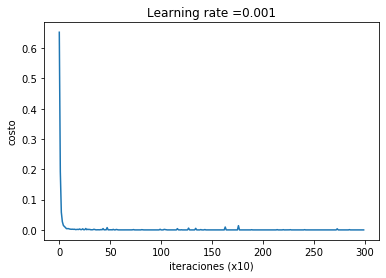

Los parametros han sido entrenados!
Train Accuracy: 1.0
Test Accuracy: 1.0
W1=  [[-8.90851766e-02 -3.99135090e-02  8.66305053e-01 -3.52533042e-01
   9.68695134e-02 -5.53956851e-02  9.93008018e-01  2.93881923e-01
  -9.06771302e-01 -1.18392479e+00  8.74689370e-02  4.82719302e-01
   1.12847373e-01 -1.79565951e-01  3.84381503e-01 -6.93257549e-04
   1.06822491e-01 -2.31070191e-01 -5.31436026e-01 -4.54198092e-01
   7.24610150e-01 -2.82570124e-01  2.90939480e-01 -6.51511252e-02
  -1.27486616e-01 -2.20880285e-01 -1.14473127e-01 -3.01972359e-01
  -8.11147511e-01 -1.73225984e-01 -3.92319202e-01 -1.88716590e-01
  -3.96664560e-01  1.72267869e-01  2.94927359e-01  8.31410527e-01
   5.71892262e-01  8.49555194e-01  6.01277828e-01  9.65144560e-02
  -4.18032438e-01 -5.87527335e-01  9.66063216e-02  4.64308321e-01
  -4.05134439e-01 -3.46912831e-01 -2.30584502e-01 -6.42587364e-01
   3.55007172e-01 -2.77498573e-01  1.00128675e+00 -3.28556657e-01
   4.30718869e-01]
 [ 1.15450554e-01  3.83042470e-02 -2.773297

In [23]:
#parameters = model(X_train_norm, Y_Train, X_train_norm, Y_Train)
parameters = model(X_train_std, Y_Train, X_train_std, Y_Train)